# **IMBD Movie Reviews**

## Overview
Internet Movie Database (IMDb) is an online resource that provides extensive information and statistics on movies, TV shows, and video games, along with details about actors, directors, and other professionals in the film industry. It includes lists of cast and crew members, release dates, box office data, plot summaries, trailers, biographies of actors and directors, and various trivia.

#### Data Description
This dataset comprises of 50,000 movie reviews each labeled with either positive (e.g., rating above 6/10) or negative sentiment (e.g., rating below 5/10).

- '`reviews'`: Text data from user-submitted movie reviews.
- '`sentiment`': Sentiment labels, each review is labeled as either positive (e.g., rating above 6/10) or negative (e.g., rating below 5/10).


<a id='cont'></a>

## Table of Contents
- [1. Import Packages](#one)
- [2. Load Data](#two)
- [3. Exploratory Data Analysis (EDA)](#three)
- [4. Feature Engineering](#four)
- [5. Modeling](#five)
- [6. Model Explanation](#six)
- [7. Model Evaluation](#seven)
- [8. Model Deployment](#eight)
- [9. Conclusion](#nine)

<a id='one'></a>
# 1. Import Packages 
[Back to Table of Contents](#cont)

----

In [44]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import joblib

<a id='two'></a>
# 2. Load Data
[Back to Table of Contents](#cont)

---

In [45]:
imdb = pd.read_csv("IMDB Dataset.csv")

<a id="three"></a>
# 3. Exploratory Data Analysis (EDA)
[Back to Table of Contents](#cont)

---

In [46]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [47]:
imdb.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [48]:
# Display basic information about the data
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [49]:
# Display descriptive statistics about the data
imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [50]:
imdb.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  This show comes up with interesting locations ...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [51]:
# Check for missing values in the data
imdb_missing_values = imdb.isnull().sum()
imdb_missing_values

review       0
sentiment    0
dtype: int64

##### Review Length Column 
A '`length`' column to display the length of each review ('`review`')

In [52]:
imdb['length'] = imdb['review'].apply(len)

In [53]:
imdb.columns

Index(['review', 'sentiment', 'length'], dtype='object')

In [54]:
imdb.head()

,review,sentiment,length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


<Axes: ylabel='Frequency'>

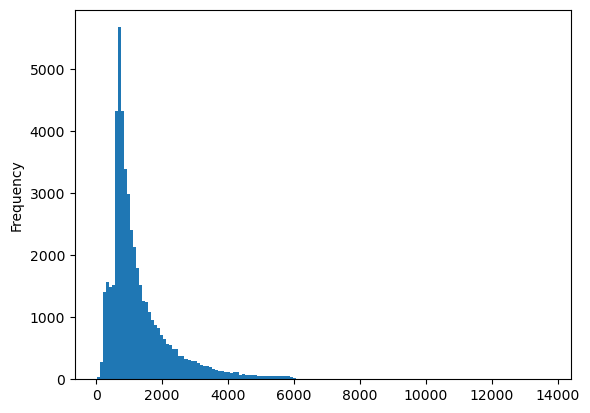

In [55]:
imdb['length'].plot.hist(bins=150)

In [56]:
# Display descriptive statistics of the length column
imdb.length.describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: length, dtype: float64

- Review text length goes up to `13704`.

In [57]:
imdb[imdb['length'] == 13704]['review'].iloc[0]

'Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, bu

- This is the longest review (`13704` characters) in the reviews dataset.

array([<Axes: title={'center': 'negative'}>,
       <Axes: title={'center': 'positive'}>], dtype=object)

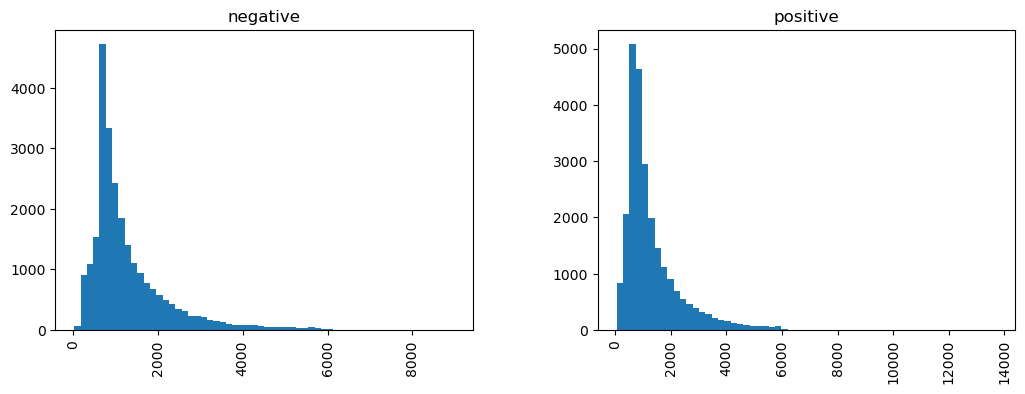

In [58]:
imdb.hist(column='length', by='sentiment',bins=60, figsize=(12,4))

- `length` is a good feature to distinguish between `negative` & `positive` reviews.

<Axes: xlabel='sentiment', ylabel='length'>

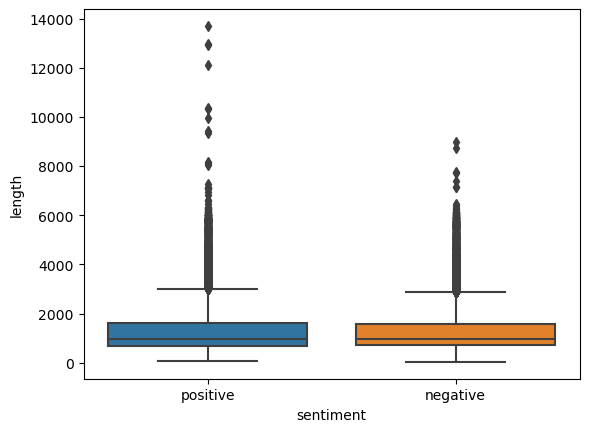

In [59]:
sns.boxplot(x='sentiment', y='length', data=imdb)

<Axes: xlabel='sentiment', ylabel='count'>

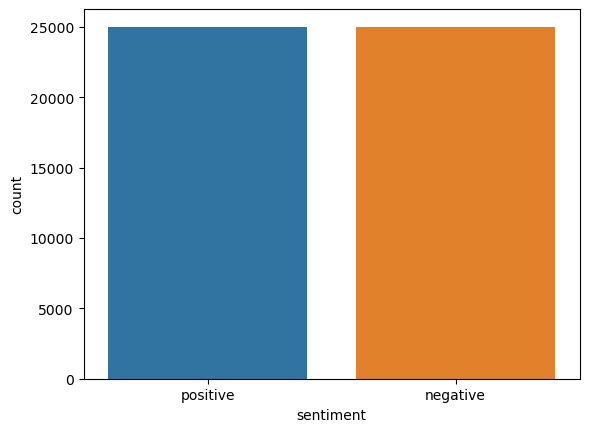

In [60]:
sns.countplot(x='sentiment', data=imdb)

- There seems to be an equal distribution between `positive`and `negative` sentiments in the reviews dataset. 

<a id="four"></a>
# 4. Feature Engineering
[Back to Table of Contents](#cont)

---

#### Column to display the sentiments as binary values

In [61]:
imdb['label'] = imdb['sentiment'].apply(lambda x:1 if x=='positive' else 0)

- Created a column `'label'` where `1` represents  `positive` sentiments and  `0` represents `negative` sentiments. 

In [62]:
imdb.columns

Index(['review', 'sentiment', 'length', 'label'], dtype='object')

#### Text Processing

In [63]:
stopwords_set = set(stopwords.words('english'))

In [64]:
def clean(text):
    text = str(text).lower()
    text = re.sub(r"\[.*?]", '', text)
    text = re.sub(r"https?://\S+|www\.\S+", '', text)
    text = re.sub(r"<.*?>+", '', text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub(r"\n", '', text)
    text = re.sub(r"\b\w*d\w*\b", '', text)
    text = ' '.join(word for word in text.split() if word not in stopwords_set)
    return text


Apply the above function `clean(text)` to the dataFrame to clean the text-data in the `'reviews'` column. 

In [65]:
imdb['review'] = imdb['review'].apply(clean)

Check a few reviews to verify if the function applied onto the dataFrame has worked. 

In [66]:
imdb['review'][0]

'one reviewers watching 1 oz youll right exactly methe first thing struck oz brutality unflinching scenes violence set right go trust show faint show pulls punches sex violence classic use oz nickname given maximum security state penitentary focuses mainly city experimental section prison cells glass fronts face privacy high em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles stares agreements never far awayi say main appeal show fact goes shows forget pretty pictures mainstream forget charm forget romanceoz mess first ever saw struck nasty surreal say taste oz got high levels graphic violence violence injustice wholl nickel inmates wholl kill get away well class inmates prison bitches lack street skills prison experience watching oz may become comfortable uncomfortable viewingthats get touch'

In [67]:
imdb[imdb['length'] == 13704]['review'].iloc[0]

'match 1 tag team table match bubba ray spike vs guerrero chris benoit bubba ray spike things tag team table match guerrero chris benoit rules match opponents go tables get win benoit guerrero early taking turns hammering first spike bubba ray german suplex benoit bubba took brother spike help brother referee benoit guerrero corner benoit stomping away bubba guerrero set table spike ring top rope onto guerrero recovering taking care spike guerrero table ring wolverine set set superplex rope put bubba table spike table right brother came crashing guerrero benoit another table corner irish whip spike bubba brother bubba caught fire opponents back bubba guerrero spike wolverine top rope bubba benoit bay spike soar wassup shortly benoit spike crossface match even spike bubba came brothers rescue sprawl benoit table bubba leapt rope benoit sent bubba crashing opponents force table bubba stay match first man shortly though spike put table ring apron benoit put spike table moments later even 

<a id="five"></a>
# 5. Modeling
[Back to Table of Contents](#cont)

---

#### Split the dataset into independent (x variable), dependent (target variable) and validation datasets.

In [68]:
X = imdb['review']
y = imdb['label']

- Two objects X and y. X is the '`review`' column of reviews_class and y is the '`label`' column.

#### Train-Test Split

- Train: used for training the model.
- Test: used for the evaluation of the model performance

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [70]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000,)
Shape of y_train: (40000,)
Shape of X_test: (10000,)
Shape of y_test: (10000,)


In [71]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()), 
    ('classifier', LogisticRegression())   
])

In [72]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

<a id="six"></a>
# 6. Model Explanation
[Back to Table of Contents](#cont)

---


<a id="seven"></a>
# 7. Model Evaluation
[Back to Table of Contents](#cont)

---

<a id="eight"></a>

# 8. Model Deployment
[Back to Table of Contents](#cont)

---

<a id='nine'></a>
# 9. Conclusion
[Back to Table of Contents](#cont)

---